In [26]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing # экспоненциальное сглаживание
from statsmodels.tsa.stattools import adfuller # проверка на стационарность ряда
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm # Для определения гиперпараметров модели

In [28]:
df22 = pd.read_csv('data/2022.csv')
df23 = pd.read_csv('data/2023.csv')
df24 = pd.read_csv('data/2024.csv')
df25 = pd.read_csv('data/2025.csv')

In [29]:
# Соединим таблицы 
df = pd.concat([df22,df23,df24,df25], ignore_index=True,axis=0)

# Сменим название
df.columns = ['Дата','1.P вых1','2.P вых2','3.Р вых','4.T вых','5.Т вх',"6.P вх",'7.Q мгн1','8.Q мгн2', '9.Q мгн сн', '10.Q сут1', '11.Q сут2', '712.Q сут сн', '13. Т воздуха']
# Выходные расходы по 2 ниткам суммируем в 1
df['Q мгн']= df['7.Q мгн1'] + df['8.Q мгн2']
df['Q сут'] = df['10.Q сут1'] + df['11.Q сут2']
# Удаляем лишние столбцы
df = df.drop(columns=['1.P вых1','2.P вых2','7.Q мгн1','8.Q мгн2','10.Q сут1','11.Q сут2'],axis=1)
# Снова переименуем
df.columns = ['Дата','Р вых','T вых','Т вх','P вх','Q мгн сн',"Q сут сн",'Т_воздуха','Q_мгн', 'Q сут']
# Дату приведем к формату
df['Дата'] = pd.to_datetime(df['Дата'])
# Подгрузим теплоемкость
df['год'] = df['Дата'].dt.year
df['месяц'] = df['Дата'].dt.month
heat_capacity_df = pd.read_excel('data/Q по Шакше.xlsx')
# Объединяем по году и месяцу
df = df.merge(heat_capacity_df, on=['год', 'месяц'], how='left')
df = df.drop(['год', 'месяц'], axis=1)

In [30]:
df = df[df['Дата']< '2025-10-01 00:00:00']

In [31]:
df.isna().sum()

Дата              0
Р вых           234
T вых           230
Т вх            230
P вх            235
Q мгн сн        345
Q сут сн        239
Т_воздуха       235
Q_мгн           301
Q сут           265
Теплоемкость      0
dtype: int64

In [32]:
df = df[['Дата','Q сут','Т_воздуха','Теплоемкость']]

In [33]:
df = df.set_index('Дата')
df['Q сут'] = df['Q сут'].round(0)
df["Т_воздуха"] = df["Т_воздуха"].round(1)
df['Теплоемкость'] = df['Теплоемкость'].round(0)

In [12]:
df[:500].to_csv('data/bf.csv')

In [34]:
df.isna().sum()

Q сут           265
Т_воздуха       235
Теплоемкость      0
dtype: int64

# Заполним пропуски

In [35]:
# Проверяем пропуски в значениях
print("Пропуски по столбцам:")
print(df.isna().sum())

# Для числовых столбцов используем интерполяцию
numeric_cols = ['Q сут', 'Т_воздуха']
for col in numeric_cols:
    # Линейная интерполяция для временного ряда
    df[col] = df[col].interpolate(method='linear')
    
    # Если остались пропуски в начале/конце, заполняем forward/backfill
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

print("\nПосле интерполяции:")
print(df.isna().sum())

Пропуски по столбцам:
Q сут           265
Т_воздуха       235
Теплоемкость      0
dtype: int64

После интерполяции:
Q сут           0
Т_воздуха       0
Теплоемкость    0
dtype: int64


In [36]:
df

,Q сут,Т_воздуха,Теплоемкость
Дата,,,
2022-01-01 00:00:00,736448.0,-7.5,8109.0
2022-01-01 01:00:00,736448.0,-7.6,8109.0
2022-01-01 02:00:00,736448.0,-7.6,8109.0
2022-01-01 03:00:00,736448.0,-7.7,8109.0
2022-01-01 04:00:00,736448.0,-8.0,8109.0
...,...,...,...
2025-09-30 19:00:00,551553.0,4.8,8340.0
2025-09-30 20:00:00,551553.0,2.5,8340.0
2025-09-30 21:00:00,551553.0,1.1,8340.0


In [56]:
print("Информация о датафрейме:")
print(df.head())
print(f"Индекс: {df.index.name}")

# Создаем суточные данные
daily_data = []

# Получаем уникальные даты из индекса - ИСПРАВЛЕНИЕ ЗДЕСЬ
unique_dates = pd.Series(df.index.date).unique()

for i in range(len(unique_dates) - 1):
    current_date = unique_dates[i]
    next_date = unique_dates[i + 1]
    
    # Берем интервал с 13:00 текущего дня до 12:00 следующего дня
    start_time = pd.Timestamp.combine(current_date, pd.Timestamp('13:00:00').time())
    end_time = pd.Timestamp.combine(next_date, pd.Timestamp('13:00:00').time())
    
    mask = ((df.index >= start_time) & (df.index < end_time))
    
    day_data = df[mask]
    
    if len(day_data) > 0:
        # Берем значение Q_сут в 13:00 (первое значение в интервале)
        q_sut = day_data['Q сут'].iloc[0]
        
        # Считаем среднюю температуру за интервал
        avg_temp = day_data['Т_воздуха'].mean()
        
        # Теплоемкость (постоянная)
        heat_capacity = day_data['Теплоемкость'].iloc[0]
        
        daily_data.append({
            'date': current_date,
            'Q_сут': q_sut,
            'Т_воздуха_средняя': avg_temp,
            'Теплоемкость': heat_capacity
        })

# Создаем новый DataFrame с суточными данными
daily_df = pd.DataFrame(daily_data)
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')

print("\nСуточные данные:")
print(daily_df.head())
print(f"\nРазмерность суточных данных: {daily_df.shape}")

Информация о датафрейме:
                        Q сут  Т_воздуха  Теплоемкость
Дата                                                  
2022-01-01 00:00:00  736448.0       -7.5        8109.0
2022-01-01 01:00:00  736448.0       -7.6        8109.0
2022-01-01 02:00:00  736448.0       -7.6        8109.0
2022-01-01 03:00:00  736448.0       -7.7        8109.0
2022-01-01 04:00:00  736448.0       -8.0        8109.0
Индекс: Дата

Суточные данные:
               Q_сут  Т_воздуха_средняя  Теплоемкость
date                                                 
2022-01-01  692327.0          -6.195833        8109.0
2022-01-02  691338.0          -4.141667        8109.0
2022-01-03  660918.0         -11.550000        8109.0
2022-01-04  712526.0         -18.562500        8109.0
2022-01-05  748779.0         -24.616667        8109.0

Размерность суточных данных: (1368, 3)


In [57]:
daily_df

,Q_сут,Т_воздуха_средняя,Теплоемкость
date,,,
2022-01-01,692327.0,-6.195833,8109.0
2022-01-02,691338.0,-4.141667,8109.0
2022-01-03,660918.0,-11.550000,8109.0
2022-01-04,712526.0,-18.562500,8109.0
2022-01-05,748779.0,-24.616667,8109.0
...,...,...,...
2025-09-25,334711.0,6.370833,8340.0
2025-09-26,448448.0,6.545833,8340.0
2025-09-27,500589.0,4.554167,8340.0


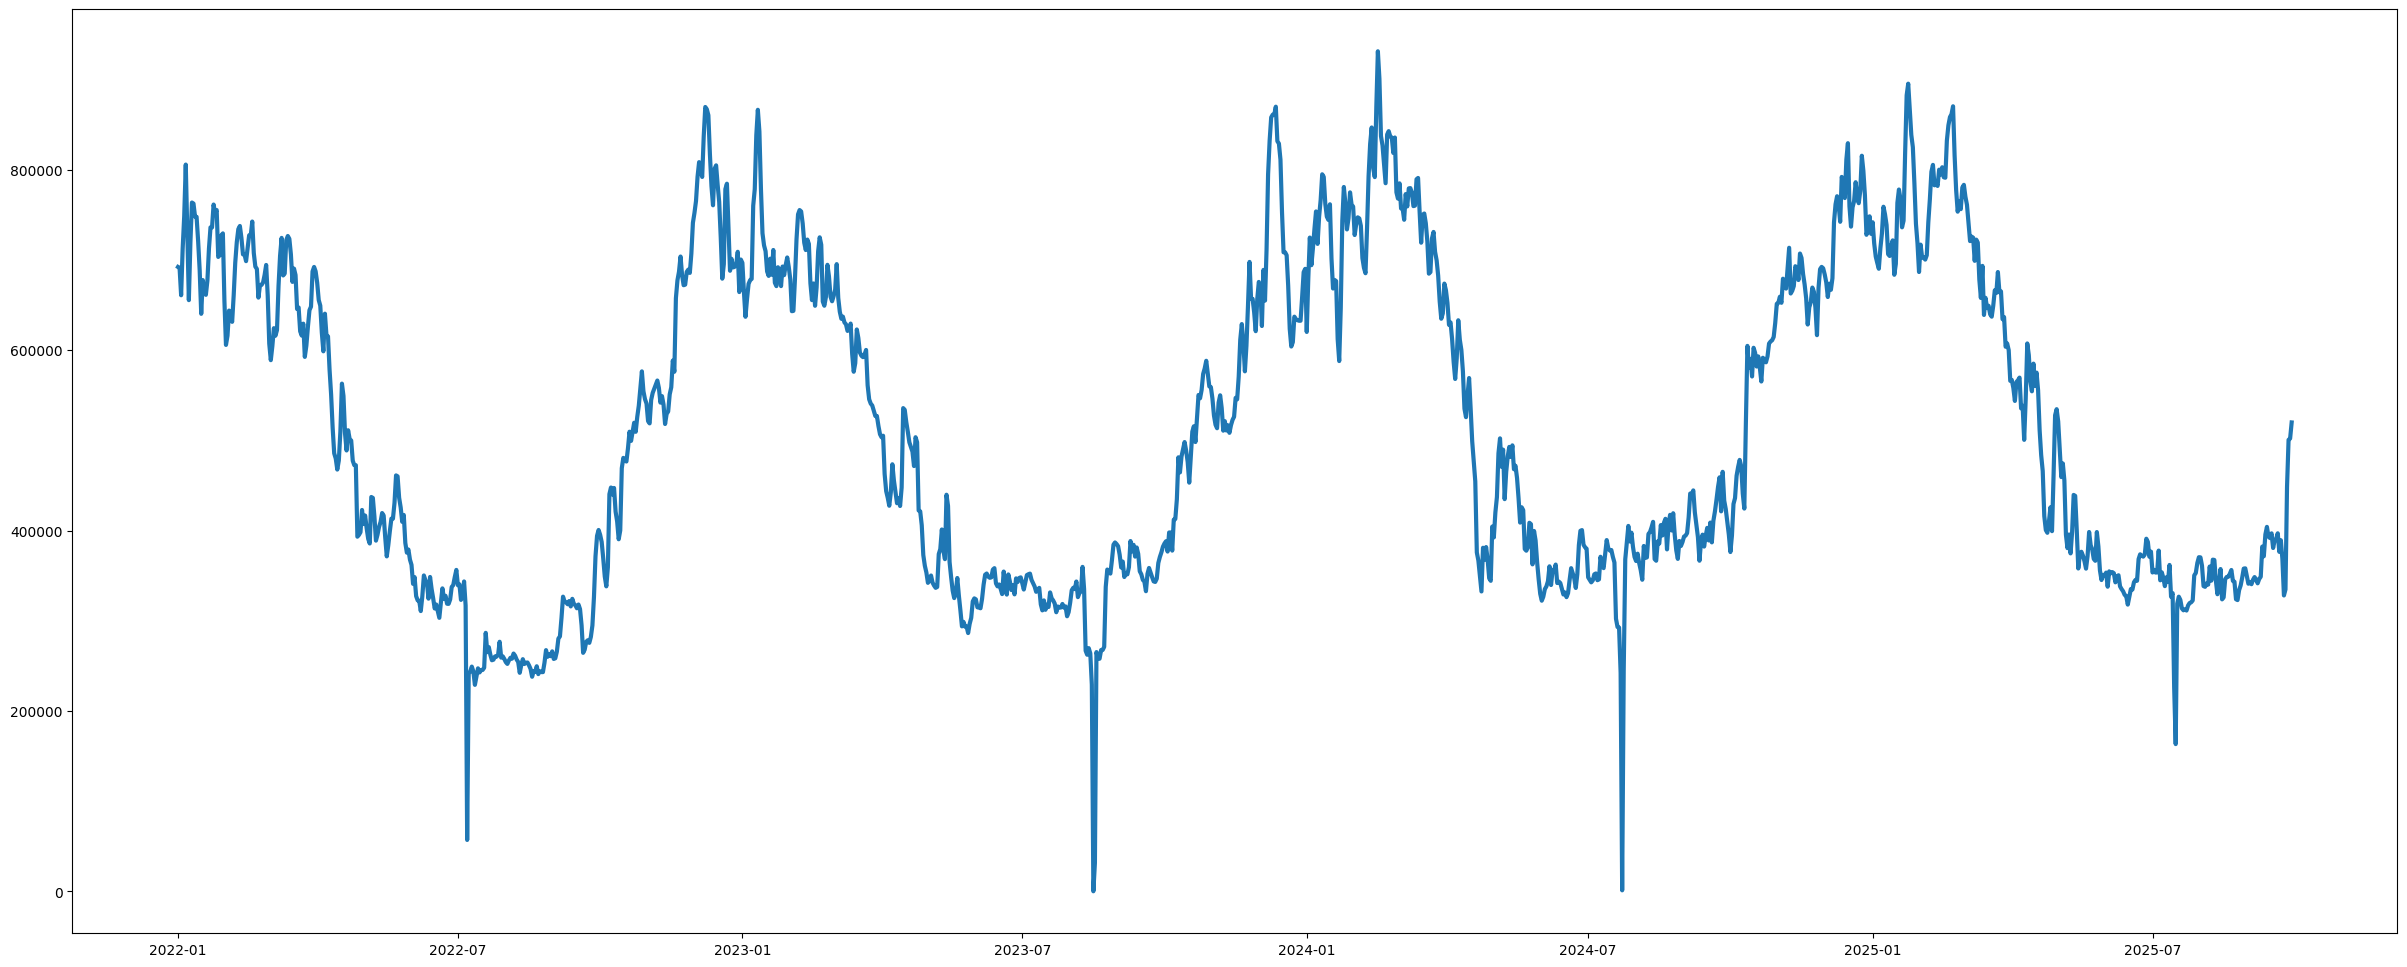

In [58]:
# Визуализация
plt.figure(figsize=(30, 12))
plt.plot(daily_df.index, daily_df['Q_сут'], linewidth=3)

## Проверка пропущенных значений

In [59]:
# Проверка непрерывности
print("Информация о временном ряде:")
print(f"Начало: {daily_df.index.min()}")
print(f"Конец: {daily_df.index.max()}")
print(f"Всего записей: {len(daily_df)}")

# Создаем полный временной диапазон
full_range = pd.date_range(start=daily_df.index.min(), end=daily_df.index.max(), freq='D')
print(f"Ожидаемое количество записей: {len(full_range)}")

# Находим пропущенные временные метки
missing_times = full_range.difference(daily_df.index)
print(f"Пропущенных временных меток: {len(missing_times)}")

if len(missing_times) > 0:
    print("\nПримеры пропущенных временных меток:")
    print(missing_times[:10])

Информация о временном ряде:
Начало: 2022-01-01 00:00:00
Конец: 2025-09-29 00:00:00
Всего записей: 1368
Ожидаемое количество записей: 1368
Пропущенных временных меток: 0


In [60]:
# Создаем признаки для временного ряда
def create_features(df, target='Q_сут', lags=3):
    df = df.copy()
    
    # Лаговые значения целевой переменной
    for i in range(1, lags + 1):
        df[f'Q_сут_lag_{i}'] = df[target].shift(i)
    
    # Лаговые значения температуры
    for i in range(1, lags + 1):
        df[f'Темп_lag_{i}'] = df['Т_воздуха_средняя'].shift(i)
    
    # День недели
    df['day_of_week'] = df.index.dayofweek
    
    # Является ли выходным
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Месяц
    df['month'] = df.index.month
    
    return df

# Создаем признаки
daily_df_features = create_features(daily_df)

# Удаляем строки с NaN
daily_df_features = daily_df_features.dropna()

print(f"\nДанные после создания признаков: {daily_df_features.shape}")

# Разделяем на признаки и целевую переменную
X = daily_df_features.drop(['Q_сут'], axis=1)
y = daily_df_features['Q_сут']

# Разделяем на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")



Данные после создания признаков: (1365, 12)
Обучающая выборка: (1092, 11)
Тестовая выборка: (273, 11)


In [64]:
y_test

date
2024-12-31    729027.0
2025-01-01    741853.0
2025-01-02    718322.0
2025-01-03    703794.0
2025-01-04    696694.0
                ...   
2025-09-25    334711.0
2025-09-26    448448.0
2025-09-27    500589.0
2025-09-28    502095.5
2025-09-29    519884.0
Name: Q_сут, Length: 273, dtype: float64

In [63]:
X_test

,Т_воздуха_средняя,Теплоемкость,Q_сут_lag_1,Q_сут_lag_2,Q_сут_lag_3,Темп_lag_1,Темп_lag_2,Темп_lag_3,day_of_week,is_weekend,month
date,,,,,,,,,,,
2024-12-31,-4.233333,8245.0,748446.0,734524.0,727979.0,-7.000000,-5.766667,-3.695833,1,0,12
2025-01-01,-4.895833,8287.0,729027.0,748446.0,734524.0,-4.233333,-7.000000,-5.766667,2,0,1
2025-01-02,-1.229167,8287.0,741853.0,729027.0,748446.0,-4.895833,-4.233333,-7.000000,3,0,1
2025-01-03,0.741667,8287.0,718322.0,741853.0,729027.0,-1.229167,-4.895833,-4.233333,4,0,1
2025-01-04,1.412500,8287.0,703794.0,718322.0,741853.0,0.741667,-1.229167,-4.895833,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25,6.370833,8340.0,328033.0,368577.0,389261.0,15.529167,20.200000,16.004167,3,0,9
2025-09-26,6.545833,8340.0,334711.0,328033.0,368577.0,6.370833,15.529167,20.200000,4,0,9
2025-09-27,4.554167,8340.0,448448.0,334711.0,328033.0,6.545833,6.370833,15.529167,5,1,9



Качество модели на тестовой выборке:
MAE: 16853.68
RMSE: 23921.17


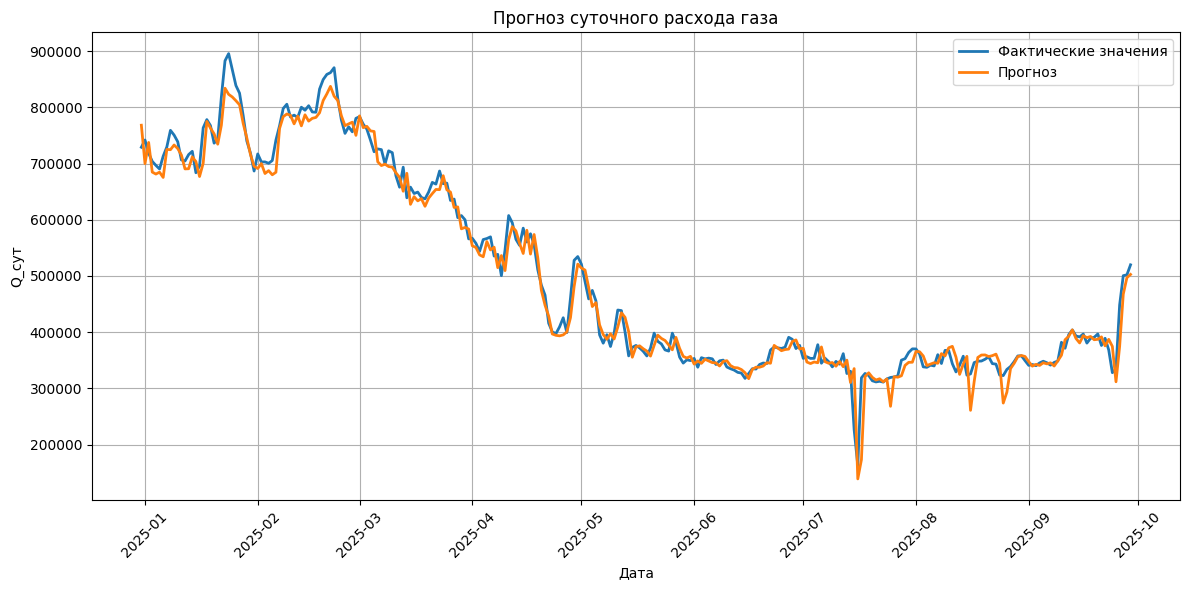


Важность признаков:
              feature  importance
2         Q_сут_lag_1    0.979207
5          Темп_lag_1    0.008431
3         Q_сут_lag_2    0.002265
1        Теплоемкость    0.002077
7          Темп_lag_3    0.001919
0   Т_воздуха_средняя    0.001793
6          Темп_lag_2    0.001509
4         Q_сут_lag_3    0.001387
8         day_of_week    0.000732
10              month    0.000595
9          is_weekend    0.000085


In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозируем
y_pred = model.predict(X_test)

# Оцениваем качество
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nКачество модели на тестовой выборке:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Визуализируем результаты
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Фактические значения', linewidth=2)
plt.plot(y_test.index, y_pred, label='Прогноз', linewidth=2)
plt.xlabel('Дата')
plt.ylabel('Q_сут')
plt.title('Прогноз суточного расхода газа')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков:")
print(feature_importance)

Сравнение качества:
Старый подход (с утечкой): MAE = 16853.68, RMSE = 23921.17
Новый подход (реалистичный): MAE = 134559.66, RMSE = 151536.67


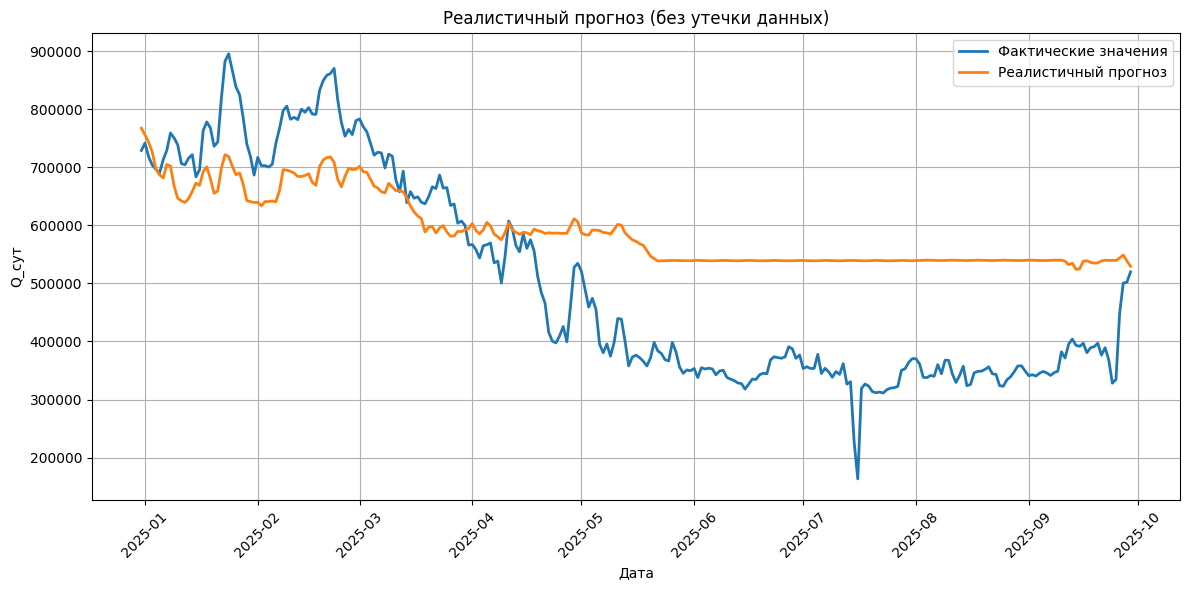

In [65]:
def evaluate_model_realistic(model, X, y, test_size=0.2):
    """
    Реалистичная оценка модели с итеративным прогнозированием на тестовой выборке
    """
    # Разделяем на train/test
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Обучаем модель
    model.fit(X_train, y_train)
    
    # Итеративный прогноз на тестовой выборке
    y_pred = []
    current_features = X_test.iloc[0:1].copy()
    
    for i in range(len(X_test)):
        # Делаем прогноз на один шаг
        pred = model.predict(current_features)[0]
        y_pred.append(pred)
        
        # Если это не последний шаг, обновляем признаки для следующего прогноза
        if i < len(X_test) - 1:
            # Сдвигаем все лаговые признаки
            next_features = current_features.copy()
            
            # Обновляем лаги расхода газа
            for lag in range(3, 1, -1):  # От lag_3 к lag_2
                next_features[f'Q_сут_lag_{lag}'] = next_features[f'Q_сут_lag_{lag-1}']
            next_features['Q_сут_lag_1'] = pred  # Используем наш прогноз!
            
            # Аналогично для температуры (если бы у нас были прогнозы температуры)
            for lag in range(3, 1, -1):
                next_features[f'Темп_lag_{lag}'] = next_features[f'Темп_lag_{lag-1}']
            # Для температуры используем фактическое значение (в реальности нужен прогноз погоды)
            next_features['Темп_lag_1'] = X_test.iloc[i+1]['Темп_lag_1']
            
            # Временные признаки берем из следующей строки тестовой выборки
            next_features['day_of_week'] = X_test.iloc[i+1]['day_of_week']
            next_features['is_weekend'] = X_test.iloc[i+1]['is_weekend']
            next_features['month'] = X_test.iloc[i+1]['month']
            
            current_features = next_features
    
    return y_test, y_pred

# Пересоздаем признаки БЕЗ утечки данных
def create_features_safe(df, target='Q_сут', lags=3):
    df = df.copy()
    
    # Лаговые значения
    for i in range(1, lags + 1):
        df[f'Q_сут_lag_{i}'] = df[target].shift(i)
        df[f'Темп_lag_{i}'] = df['Т_воздуха_средняя'].shift(i)
    
    # Временные признаки
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['month'] = df.index.month
    
    return df

# Применяем безопасное создание признаков
daily_df_features_safe = create_features_safe(daily_df)
daily_df_features_safe = daily_df_features_safe.dropna()

X_safe = daily_df_features_safe.drop(['Q_сут', 'Теплоемкость'], axis=1)
y_safe = daily_df_features_safe['Q_сут']

# Оцениваем модель реалистично
y_test_real, y_pred_real = evaluate_model_realistic(model, X_safe, y_safe)

# Сравниваем качество
mae_real = mean_absolute_error(y_test_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("Сравнение качества:")
print(f"Старый подход (с утечкой): MAE = {mae:.2f}, RMSE = {rmse:.2f}")
print(f"Новый подход (реалистичный): MAE = {mae_real:.2f}, RMSE = {rmse_real:.2f}")

# Визуализируем
plt.figure(figsize=(12, 6))
plt.plot(y_test_real.index, y_test_real.values, label='Фактические значения', linewidth=2)
plt.plot(y_test_real.index, y_pred_real, label='Реалистичный прогноз', linewidth=2)
plt.xlabel('Дата')
plt.ylabel('Q_сут')
plt.title('Реалистичный прогноз (без утечки данных)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Проверка

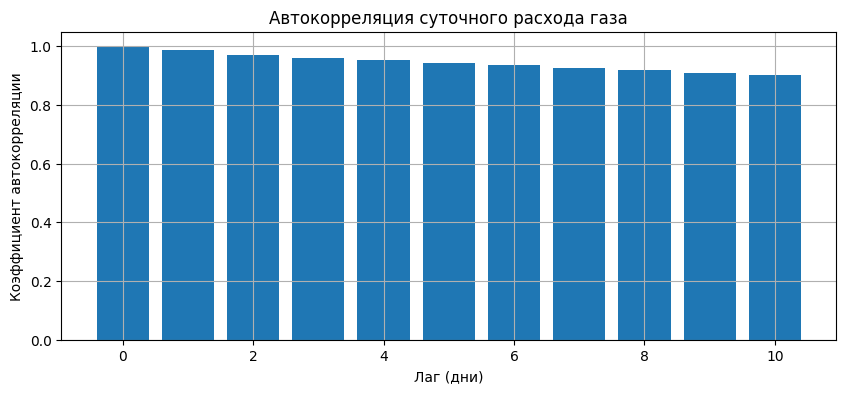

Коэффициенты автокорреляции:
Лаг 0: 1.000
Лаг 1: 0.987
Лаг 2: 0.972
Лаг 3: 0.962
Лаг 4: 0.953
Лаг 5: 0.945
Лаг 6: 0.935
Лаг 7: 0.926
Лаг 8: 0.918
Лаг 9: 0.911
Лаг 10: 0.904


In [46]:
# Проверим автокорреляцию
from statsmodels.tsa.stattools import acf

lags = 10
autocorrelation = acf(daily_df['Q_сут'], nlags=lags)

plt.figure(figsize=(10, 4))
plt.bar(range(lags+1), autocorrelation)
plt.title('Автокорреляция суточного расхода газа')
plt.xlabel('Лаг (дни)')
plt.ylabel('Коэффициент автокорреляции')
plt.grid(True)
plt.show()

print("Коэффициенты автокорреляции:")
for i, ac in enumerate(autocorrelation):
    print(f"Лаг {i}: {ac:.3f}")

In [47]:
# Проверим структуру данных более внимательно
print("Первые 10 строк суточных данных:")
print(daily_df.head(10))

# Проверим, как создавались признаки
print("\nПроверка лаговых признаков:")
print(daily_df_features[['Q_сут', 'Q_сут_lag_1', 'Q_сут_lag_2', 'Q_сут_lag_3']].head(10))

# Проверим корреляцию целевой переменной с лагами
correlation_with_lags = daily_df_features[[f'Q_сут_lag_{i}' for i in range(1, 4)]].corrwith(daily_df_features['Q_сут'])
print(f"\nКорреляция с лагами:")
print(correlation_with_lags)

Первые 10 строк суточных данных:
               Q_сут  Т_воздуха_средняя  Теплоемкость
date                                                 
2022-01-01  692327.0          -6.195833        8109.0
2022-01-02  691338.0          -4.141667        8109.0
2022-01-03  660918.0         -11.550000        8109.0
2022-01-04  712526.0         -18.562500        8109.0
2022-01-05  748779.0         -24.616667        8109.0
2022-01-06  805819.0          -4.741667        8109.0
2022-01-07  732534.0           0.058333        8109.0
2022-01-08  655502.0          -9.262500        8109.0
2022-01-09  719146.0         -14.704167        8109.0
2022-01-10  763730.0         -10.854167        8109.0

Проверка лаговых признаков:
               Q_сут  Q_сут_lag_1  Q_сут_lag_2  Q_сут_lag_3
date                                                       
2022-01-04  712526.0     660918.0     691338.0     692327.0
2022-01-05  748779.0     712526.0     660918.0     691338.0
2022-01-06  805819.0     748779.0     712526.0    

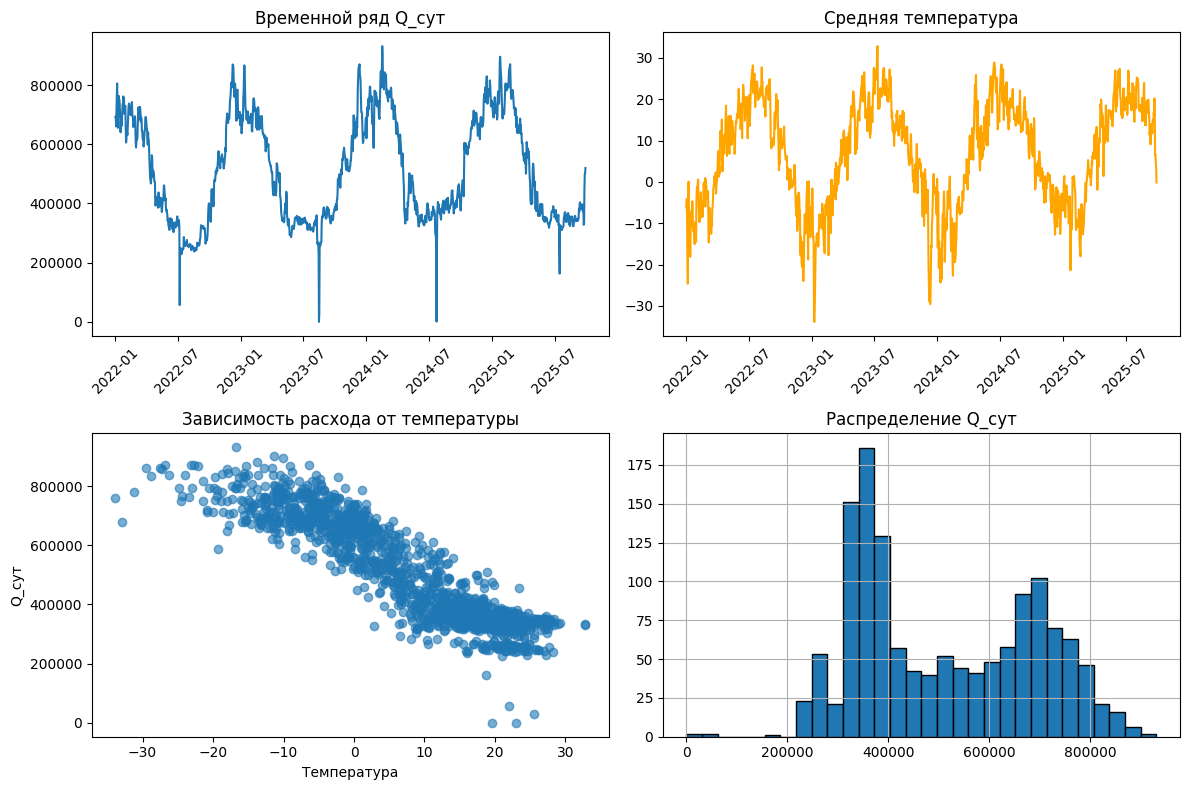

Описательная статистика:
               Q_сут  Т_воздуха_средняя  Теплоемкость
count    1368.000000        1368.000000   1368.000000
mean   510847.359644           6.725058   8277.024123
std    176733.638204          12.628400     61.315523
min         0.000000         -33.854167   8109.000000
25%    351996.500000          -2.858333   8242.000000
50%    477477.500000           8.341667   8283.000000
75%    677554.750000          17.230208   8309.000000
max    931457.000000          32.837500   8428.000000


In [48]:
# Анализ стабильности данных
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(daily_df.index, daily_df['Q_сут'])
plt.title('Временной ряд Q_сут')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(daily_df.index, daily_df['Т_воздуха_средняя'], color='orange')
plt.title('Средняя температура')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.scatter(daily_df['Т_воздуха_средняя'], daily_df['Q_сут'], alpha=0.6)
plt.xlabel('Температура')
plt.ylabel('Q_сут')
plt.title('Зависимость расхода от температуры')

plt.subplot(2, 2, 4)
daily_df['Q_сут'].hist(bins=30, edgecolor='black')
plt.title('Распределение Q_сут')

plt.tight_layout()
plt.show()

# Статистика данных
print("Описательная статистика:")
print(daily_df.describe())

Качество на последних 20% данных:
MAE: 15671.90
RMSE: 21939.21


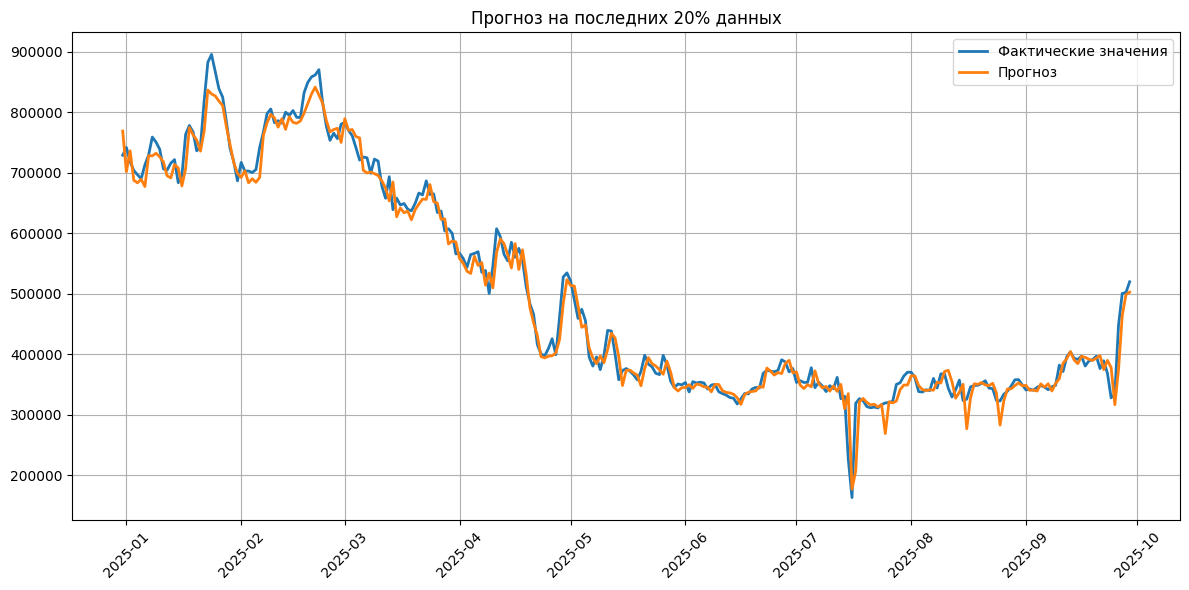

In [49]:
# Разделим данные по-другому - возьмем последние 20% как тест
test_size_days = int(len(daily_df_features) * 0.2)
X_train_new = daily_df_features[:-test_size_days].drop(['Q_сут', 'Теплоемкость'], axis=1)
X_test_new = daily_df_features[-test_size_days:].drop(['Q_сут', 'Теплоемкость'], axis=1)
y_train_new = daily_df_features[:-test_size_days]['Q_сут']
y_test_new = daily_df_features[-test_size_days:]['Q_сут']

model_new = RandomForestRegressor(n_estimators=100, random_state=42)
model_new.fit(X_train_new, y_train_new)
y_pred_new = model_new.predict(X_test_new)

mae_new = mean_absolute_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mean_squared_error(y_test_new, y_pred_new))

print(f"Качество на последних 20% данных:")
print(f"MAE: {mae_new:.2f}")
print(f"RMSE: {rmse_new:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(y_test_new.index, y_test_new.values, label='Фактические значения', linewidth=2)
plt.plot(y_test_new.index, y_pred_new, label='Прогноз', linewidth=2)
plt.title('Прогноз на последних 20% данных')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
from sklearn.model_selection import TimeSeriesSplit

# Кросс-валидация с учетом временного ряда
tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    model_cv = RandomForestRegressor(n_estimators=100, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)
    
    mae_cv = mean_absolute_error(y_test_cv, y_pred_cv)
    scores.append(mae_cv)

print(f"Результаты кросс-валидации:")
print(f"MAE: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

Результаты кросс-валидации:
MAE: 19546.79 ± 4083.91


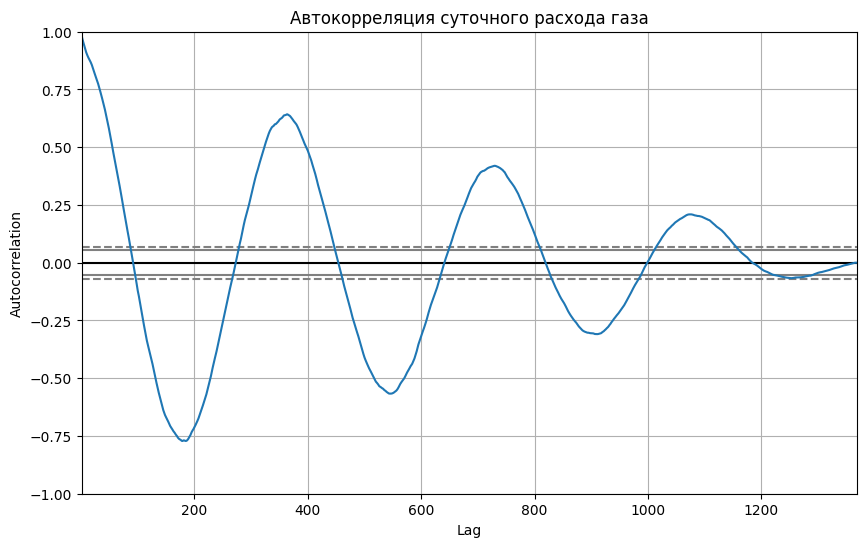

In [51]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(daily_df['Q_сут'])
plt.title('Автокорреляция суточного расхода газа')
plt.show()

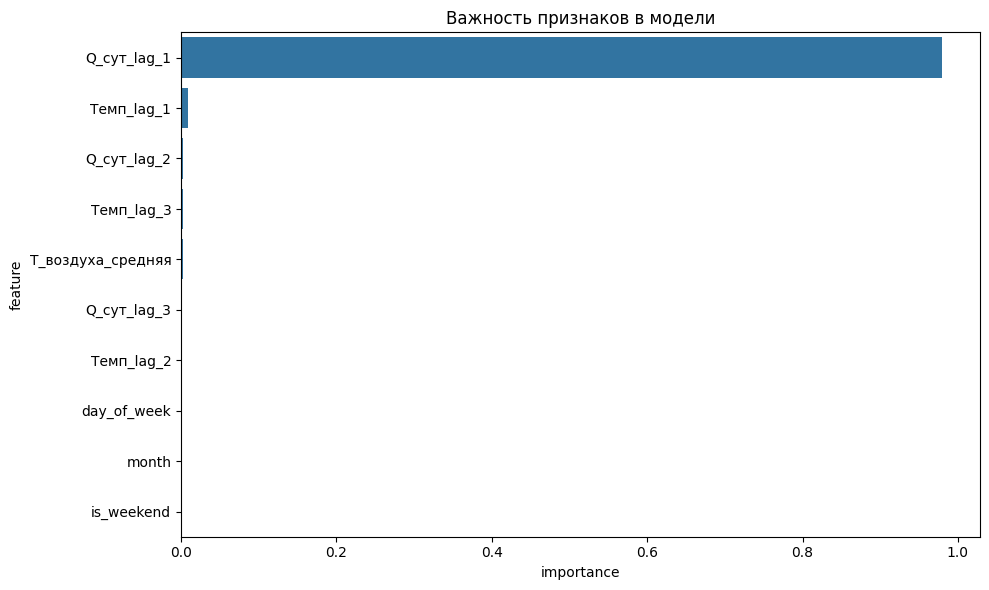

Корреляция признаков с целевой переменной:
Q_сут                1.000000
Q_сут_lag_1          0.987094
Q_сут_lag_2          0.972695
Q_сут_lag_3          0.962961
day_of_week          0.012305
is_weekend           0.012064
month               -0.279376
Теплоемкость        -0.345437
Т_воздуха_средняя   -0.908438
Темп_lag_3          -0.920326
Темп_lag_1          -0.928762
Темп_lag_2          -0.930648
Name: Q_сут, dtype: float64


In [52]:
# Более детальный анализ важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков в модели')
plt.tight_layout()
plt.show()

# Корреляция признаков с целевой переменной
correlations = daily_df_features.corr()['Q_сут'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной:")
print(correlations)

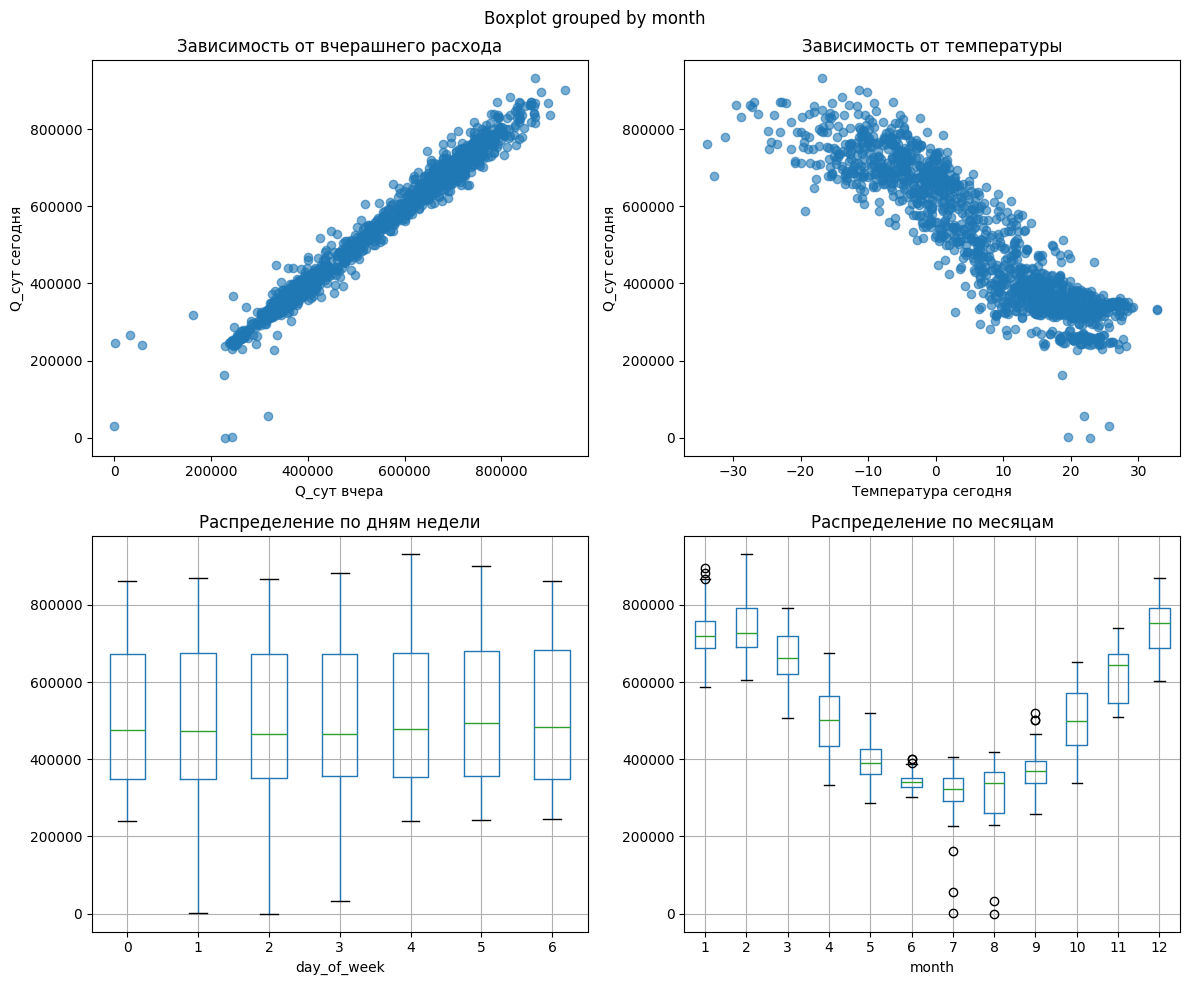

In [53]:
# Визуализируем взаимосвязи
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Зависимость от вчерашнего расхода
axes[0,0].scatter(daily_df_features['Q_сут_lag_1'], daily_df_features['Q_сут'], alpha=0.6)
axes[0,0].set_xlabel('Q_сут вчера')
axes[0,0].set_ylabel('Q_сут сегодня')
axes[0,0].set_title('Зависимость от вчерашнего расхода')

# Зависимость от температуры
axes[0,1].scatter(daily_df_features['Т_воздуха_средняя'], daily_df_features['Q_сут'], alpha=0.6)
axes[0,1].set_xlabel('Температура сегодня')
axes[0,1].set_ylabel('Q_сут сегодня')
axes[0,1].set_title('Зависимость от температуры')

# Зависимость от дня недели
daily_df_features.boxplot(column='Q_сут', by='day_of_week', ax=axes[1,0])
axes[1,0].set_title('Распределение по дням недели')

# Зависимость от месяца
daily_df_features.boxplot(column='Q_сут', by='month', ax=axes[1,1])
axes[1,1].set_title('Распределение по месяцам')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



print("Информация о датафрейме:")
print(df.head())
print(f"Индекс: {df.index.name}")

# Создаем суточные данные
daily_data = []

# Получаем уникальные даты из индекса
unique_dates = df.index.date.unique()

for i in range(len(unique_dates) - 1):
    current_date = unique_dates[i]
    next_date = unique_dates[i + 1]
    
    # Берем интервал с 13:00 текущего дня до 12:00 следующего дня
    mask = ((df.index >= pd.Timestamp(f"{current_date} 13:00:00")) & 
            (df.index < pd.Timestamp(f"{next_date} 13:00:00")))
    
    day_data = df[mask]
    
    if len(day_data) > 0:
        # Берем значение Q_сут в 13:00 (первое значение в интервале)
        q_sut = day_data['Q сут'].iloc[0]
        
        # Считаем среднюю температуру за интервал
        avg_temp = day_data['Т_воздуха'].mean()
        
        # Теплоемкость (постоянная)
        heat_capacity = day_data['Теплоемкость'].iloc[0]
        
        daily_data.append({
            'date': current_date,
            'Q_сут': q_sut,
            'Т_воздуха_средняя': avg_temp,
            'Теплоемкость': heat_capacity
        })

# Создаем новый DataFrame с суточными данными
daily_df = pd.DataFrame(daily_data)
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')

print("\nСуточные данные:")
print(daily_df.head())
print(f"\nРазмерность суточных данных: {daily_df.shape}")

# Создаем признаки для временного ряда
def create_features(df, target='Q_сут', lags=3):
    df = df.copy()
    
    # Лаговые значения целевой переменной
    for i in range(1, lags + 1):
        df[f'Q_сут_lag_{i}'] = df[target].shift(i)
    
    # Лаговые значения температуры
    for i in range(1, lags + 1):
        df[f'Темп_lag_{i}'] = df['Т_воздуха_средняя'].shift(i)
    
    # День недели
    df['day_of_week'] = df.index.dayofweek
    
    # Является ли выходным
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Месяц
    df['month'] = df.index.month
    
    return df

# Создаем признаки
daily_df_features = create_features(daily_df)

# Удаляем строки с NaN
daily_df_features = daily_df_features.dropna()

print(f"\nДанные после создания признаков: {daily_df_features.shape}")

# Разделяем на признаки и целевую переменную
X = daily_df_features.drop(['Q_сут', 'Теплоемкость'], axis=1)
y = daily_df_features['Q_сут']

# Разделяем на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозируем
y_pred = model.predict(X_test)

# Оцениваем качество
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nКачество модели на тестовой выборке:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Визуализируем результаты
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Фактические значения', linewidth=2)
plt.plot(y_test.index, y_pred, label='Прогноз', linewidth=2)
plt.xlabel('Дата')
plt.ylabel('Q_сут')
plt.title('Прогноз суточного расхода газа')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков:")
print(feature_importance)

# Дополнительный анализ: корреляция
plt.figure(figsize=(10, 8))
correlation_matrix = daily_df_features[['Q_сут', 'Т_воздуха_средняя'] + 
                                      [f'Q_сут_lag_{i}' for i in range(1, 4)]].corr()

import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

# Анализ остатков
residuals = y_test - y_pred
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Прогноз')
plt.ylabel('Остатки')
plt.title('Остатки vs Прогноз')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

print(f"\nСреднее остатков: {residuals.mean():.2f}")
print(f"Стандартное отклонение остатков: {residuals.std():.2f}")

Информация о датафрейме:
                        Q сут  Т_воздуха  Теплоемкость
Дата                                                  
2022-01-01 00:00:00  736448.0       -7.5        8109.0
2022-01-01 01:00:00  736448.0       -7.6        8109.0
2022-01-01 02:00:00  736448.0       -7.6        8109.0
2022-01-01 03:00:00  736448.0       -7.7        8109.0
2022-01-01 04:00:00  736448.0       -8.0        8109.0
Индекс: Дата


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

# Подготовка данных

## Проверка пропущенных временных интервалов

In [ ]:

# Проверка непрерывности
print("Информация о временном ряде:")
print(f"Начало: {df_da.index.min()}")
print(f"Конец: {df_base.index.max()}")
print(f"Всего записей: {len(df_base)}")

# Создаем полный временной диапазон
full_range = pd.date_range(start=df_base.index.min(), end=df_base.index.max(), freq='H')
print(f"Ожидаемое количество записей: {len(full_range)}")

# Находим пропущенные временные метки
missing_times = full_range.difference(df_base.index)
print(f"Пропущенных временных меток: {len(missing_times)}")

if len(missing_times) > 0:
    print("\nПримеры пропущенных временных меток:")
    print(missing_times[:10])

Информация о временном ряде:
Начало: 2022-01-01 00:00:00
Конец: 2025-09-30 23:00:00
Всего записей: 32856
Ожидаемое количество записей: 32856
Пропущенных временных меток: 0


## Интерполяция пропусков

In [54]:
# Проверяем пропуски в значениях
print("Пропуски по столбцам:")
print(df_base.isna().sum())

# Интерполяция пропусков
df_filled = df_base.copy()

# Для числовых столбцов используем интерполяцию
numeric_cols = ['Q_мгн', 'Т_воздуха']
for col in numeric_cols:
    # Линейная интерполяция для временного ряда
    df_filled[col] = df_filled[col].interpolate(method='linear')
    
    # Если остались пропуски в начале/конце, заполняем forward/backfill
    df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')

print("\nПосле интерполяции:")
print(df_filled.isna().sum())

Пропуски по столбцам:
Q_мгн           301
Т_воздуха       235
Теплоемкость      0
dtype: int64

После интерполяции:
Q_мгн           0
Т_воздуха       0
Теплоемкость    0
dtype: int64


## Обработка выбросов

### 1. Мгновенный расход

Выбросы удалим с помощью сглаживания с окном 5


In [55]:
# Функция для анализа разных окон сглаживания
def analyze_smoothing(df, column='Q_мгн', windows=[3, 5, 7, 12, 24]):
    fig, axes = plt.subplots(len(windows) + 1, 1, figsize=(15, 4 * (len(windows) + 1)))
    
    # Исходные данные
    axes[0].plot(df.index, df[column], 'b-', alpha=0.7, linewidth=1, label='Исходные')
    axes[0].set_title('Исходные данные')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Сглаженные данные для разных окон
    for i, window in enumerate(windows, 1):
        smoothed = df[column].rolling(window=window, center=True).mean()
        axes[i].plot(df.index, df[column], 'gray', alpha=0.3, linewidth=0.5, label='Исходные')
        axes[i].plot(df.index, smoothed, 'r-', linewidth=1.5, label=f'Сглаживание (окно={window})')
        axes[i].set_title(f'Сглаживание с окном {window}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Убрали проблемную строку с возвратом
    # Функция теперь только визуализирует, не возвращает данные

# Анализ сглаживания
analyze_smoothing(df_filled, 'Q_мгн')

# Выбираем оптимальное окно и применяем
optimal_window = 5  # Начнем с этого, потом можно изменить
df_filled['Q_мгн_smoothed'] = df_filled['Q_мгн'].rolling(window=optimal_window, center=True).mean()

# Заполняем пропуски после rolling
df_filled['Q_мгн_smoothed'] = df_filled['Q_мгн_smoothed'].fillna(df_filled['Q_мгн'])

KeyboardInterrupt: 

### 2. Температура воздуха

Выбросы удалим с помощью метода Тьюки

In [ ]:
# Обработка выбросов в температуре интерполяцией
def handle_temperature_outliers(df, column='Т_воздуха'):
    # Определяем границы выбросов
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Создаем копию столбца
    cleaned = df[column].copy()
    
    # Помечаем выбросы как NaN
    outlier_mask = (cleaned < lower_bound) | (cleaned > upper_bound)
    cleaned[outlier_mask] = np.nan
    
    print(f"Обнаружено выбросов в температуре: {outlier_mask.sum()}")
    
    # Интерполируем пропуски (выбросы)
    cleaned = cleaned.interpolate(method='time')  # метод 'time' учитывает временные интервалы
    
    # Если остались пропуски в начале/конце, заполняем соседними значениями
    cleaned = cleaned.fillna(method='bfill').fillna(method='ffill')
    
    return cleaned, outlier_mask

# Применяем обработку
df_filled['Т_воздуха_cleaned'], temp_outlier_mask = handle_temperature_outliers(df_filled)

Обнаружено выбросов в температуре: 47


In [ ]:
df_filled = df_filled[['Q_мгн_smoothed','Т_воздуха_cleaned','Теплоемкость']]

In [ ]:
df_filled.columns = ['Q_мгн','Т_воздуха','Теплоемкость']

## Получили таблицу для работы без выбросов и пропусков

In [ ]:
df_filled.head(1)

,Q_мгн,Т_воздуха,Теплоемкость
Дата,,,
2022-01-01,29453.0,-7.5,8109.0


In [ ]:
df_filled[800:].to_csv('data/df_filled.csv')

## Разложим график на составляющие

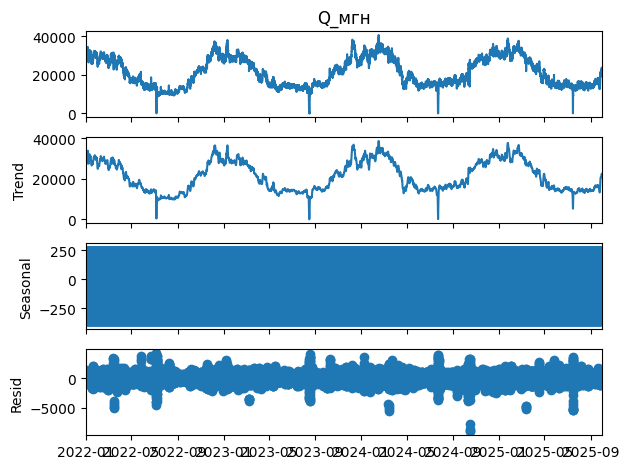

In [ ]:
result = seasonal_decompose(df_filled['Q_мгн'].dropna())
fig = result.plot()
plt.show();

## Проверка на стационарность

In [ ]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(df_filled['Q_мгн'])

adf:  -3.104999246945557
p-value:  0.026185427141980362
Critical values:  {'1%': -3.4305493601932597, '5%': -2.861628112093246, '10%': -2.5668168993302585}
единичных корней нет, ряд стационарен


## Экспоненциальное сглаживание

In [ ]:
test_df = df_filled['Q_мгн'][:-1]

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(test_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast_test_df= model.forecast(1)

print(forecast_test_df)

2025-09-30 23:00:00    22293.800966
Freq: H, dtype: float64


# Корреляции

In [ ]:
# Создадим функцию для отображения ACF и PACF
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=3600)
    plot_pacf(series, ax=axes[1], lags=10, method="ywm")
    plt.show()

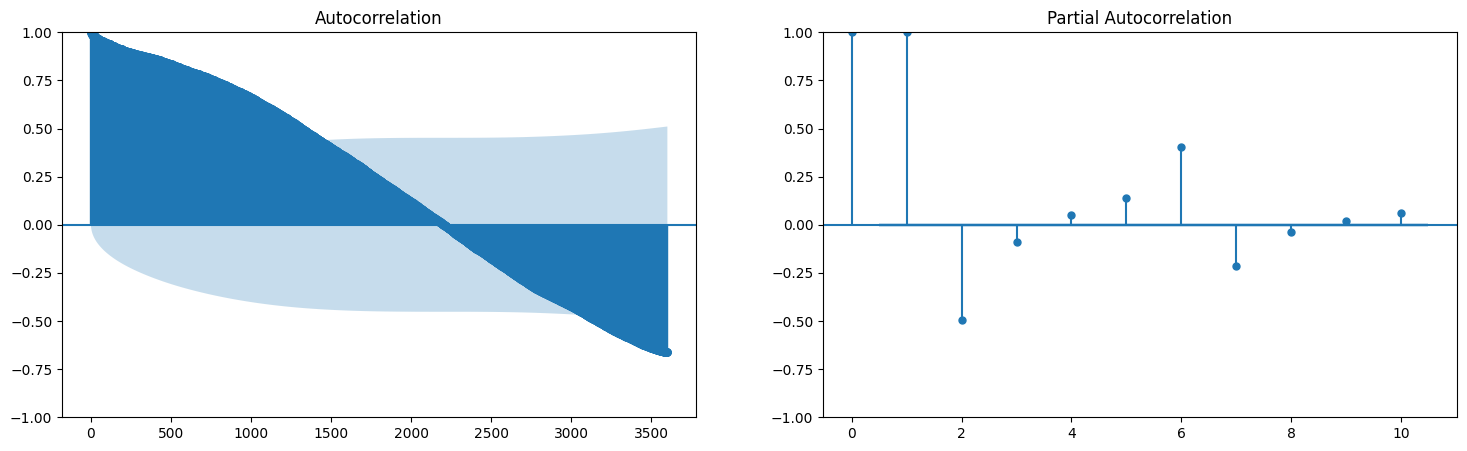

In [ ]:
plot_acf_pacf(df_filled['Q_мгн'])

# Создадим выборки

In [ ]:
train_data = df_filled[:len(df)-720]
test_data = df_filled[len(df)-720:]

# Модель AR

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
ar_model = AutoReg(train_data['Q_мгн'], lags=1).fit()
print(ar_model.summary());

                            AutoReg Model Results                             
Dep. Variable:                  Q_мгн   No. Observations:                32136
Model:                     AutoReg(1)   Log Likelihood             -226972.417
Method:               Conditional MLE   S.D. of innovations            282.634
Date:                Wed, 08 Oct 2025   AIC                         453950.833
Time:                        19:22:12   BIC                         453975.967
Sample:                    01-01-2022   HQIC                        453958.871
                         - 08-31-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8580      4.781      3.107      0.002       5.487      24.229
Q_мгн.L1       0.9993      0.000   4733.704      0.000       0.999       1.000
                                    Roots           

In [ ]:
ar_pred = ar_model.predict(start=len(train_data['Q_мгн']), end=(len(df_filled['Q_мгн'])-1), dynamic=False)

In [ ]:
ar_pred

2025-09-01 00:00:00    13669.849039
2025-09-01 01:00:00    13674.894454
2025-09-01 02:00:00    13679.936246
2025-09-01 03:00:00    13684.974420
2025-09-01 04:00:00    13690.008977
                           ...     
2025-09-30 19:00:00    16492.316593
2025-09-30 20:00:00    16495.335973
2025-09-30 21:00:00    16498.353185
2025-09-30 22:00:00    16501.368231
2025-09-30 23:00:00    16504.381113
Freq: H, Length: 720, dtype: float64

In [ ]:
# Посчитаем метрику
from sklearn.metrics import mean_squared_error

mean_squared_error(test_data['Q_мгн'], ar_pred)

5311988.483136811

                               SARIMAX Results                                
Dep. Variable:                  Q_мгн   No. Observations:                26284
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -181889.724
Date:                Wed, 08 Oct 2025   AIC                         363789.449
Time:                        19:22:14   BIC                         363830.332
Sample:                    01-01-2022   HQIC                        363802.650
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.136e+04   1358.760     15.717      0.000    1.87e+04     2.4e+04
ar.L1          1.5876      0.006    278.888      0.000       1.576       1.599
ar.L2         -0.5886      0.006   -103.444      0.0

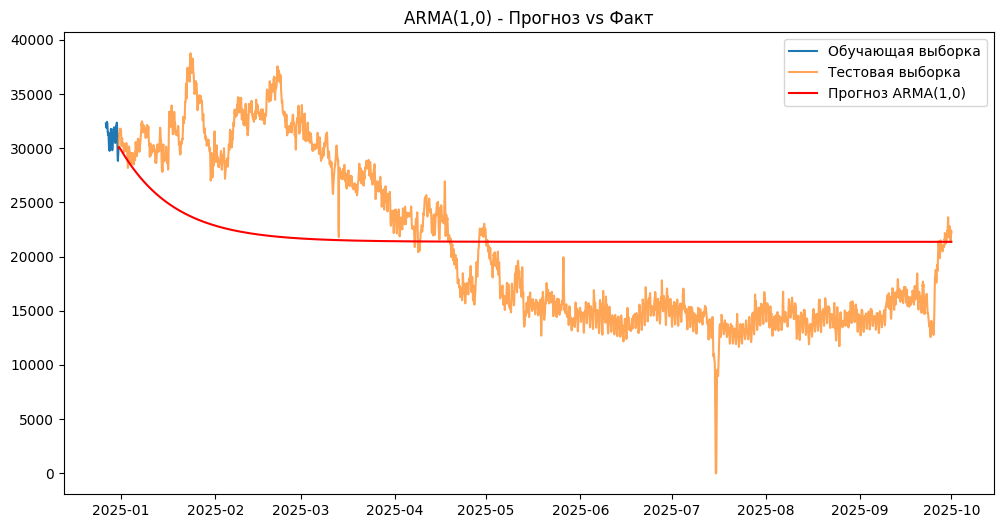

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Разделим данные на обучающую и тестовую выборки
train_size = int(len(df_filled) * 0.8)
train = df_filled['Q_мгн'][:train_size]
test = df_filled['Q_мгн'][train_size:]

# Модель ARMA(1,0) - то есть AR(1)
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

# Прогноз на тестовой выборке
forecast = model_fit.forecast(steps=len(test))

# Оценка качества
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"\nКачество модели на тестовой выборке:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
plt.plot(test.index, test.values, label='Тестовая выборка', alpha=0.7)
plt.plot(test.index, forecast, label='Прогноз ARMA(1,0)', color='red')
plt.legend()
plt.title('ARMA(1,0) - Прогноз vs Факт')
plt.show()

In [ ]:
# Для обучающей и тестовой выборок
exog_train = df_filled['Т_воздуха'][:train_size]
exog_test = df_filled['Т_воздуха'][train_size:]

model_armax = ARIMA(train, exog=exog_train, order=(1, 0, 0))
model_armax_fit = model_armax.fit()
forecast_armax = model_armax_fit.forecast(steps=len(test), exog=exog_test)


Качество модели на тестовой выборке:
MSE: 60744841.62
MAE: 6868.95


Text(0.5, 1.0, 'ARMA(1,0) - Прогноз vs Факт')

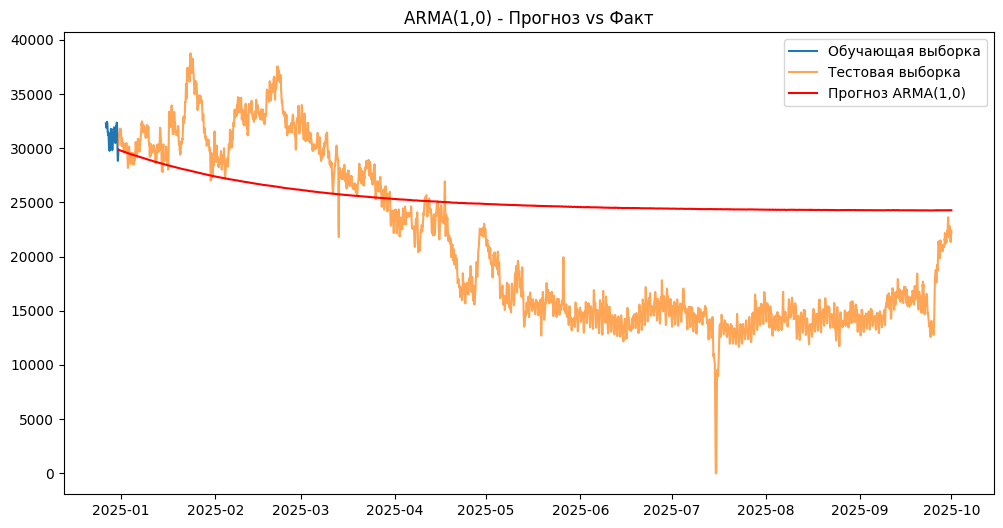

In [ ]:
# Оценка качества
mse = mean_squared_error(test, forecast_armax)
mae = mean_absolute_error(test, forecast_armax)
rmse = np.sqrt(forecast_armax)

print(f"\nКачество модели на тестовой выборке:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
plt.plot(test.index, test.values, label='Тестовая выборка', alpha=0.7)
plt.plot(test.index, forecast_armax, label='Прогноз ARMA(1,0)', color='red')
plt.legend()
plt.title('ARMA(1,0) - Прогноз vs Факт')

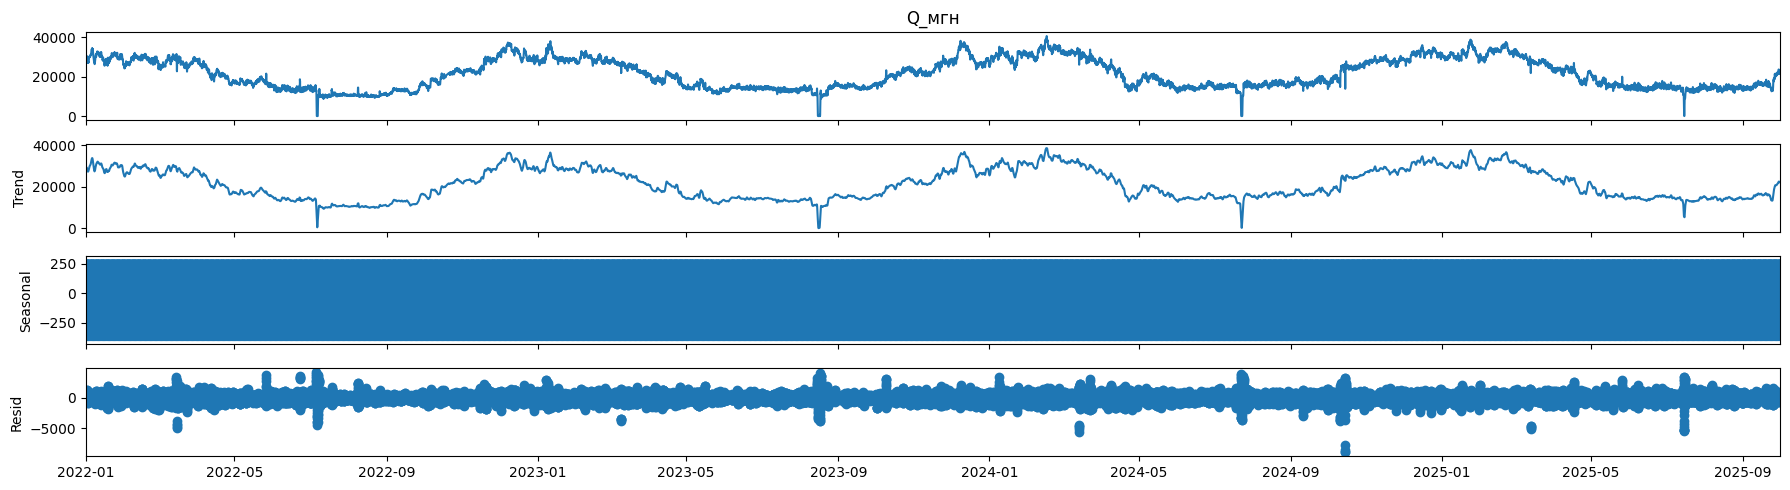

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Анализ сезонности
decomposition = seasonal_decompose(df_filled['Q_мгн'].dropna(), period=24)  # суточная сезонность
decomposition.plot()
plt.show()

# Разделение на train/test
train_size = int(len(df_filled) * 0.8)
train = df_filled['Q_мгн'][:train_size]
test = df_filled['Q_мгн'][train_size:]

In [ ]:
# Быстрый вариант с заведомо хорошими параметрами для часовых данных
try:
    # SARIMA с суточной сезонностью
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False)
    
    print(sarima_fit.summary())
    
    # Прогноз
    forecast = sarima_fit.forecast(steps=len(test))
    forecast_conf = sarima_fit.get_forecast(steps=len(test)).conf_int()
    
except Exception as e:
    print(f"Ошибка: {e}")
    # Попробуем более простую модель
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False)
    forecast = sarima_fit.forecast(steps=len(test))

                                     SARIMAX Results                                      
Dep. Variable:                              Q_мгн   No. Observations:                26284
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -181559.265
Date:                            Wed, 08 Oct 2025   AIC                         363128.530
Time:                                    19:24:51   BIC                         363169.404
Sample:                                01-01-2022   HQIC                        363141.729
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9958      0.001   1896.432      0.000       0.995       0.997
ma.L1          0.3288      0.002   

In [ ]:
# SARIMA с суточной сезонностью
model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
sarima_fit = model.fit(disp=False)
    
print(sarima_fit.summary())
    
# Прогноз
forecast = sarima_fit.forecast(steps=len(test))
forecast_conf = sarima_fit.get_forecast(steps=len(test)).conf_int()

MemoryError: Unable to allocate 501. MiB for an array with shape (26284, 50, 50) and data type float64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# Взять подвыборку для экономии памяти (первые 70%)
data = df_filled['Q_мгн']

# Разделение на train/test
train_size = int(len(data) * 0.9)
train = data[:train_size]
test = data[train_size:]

print(f"Размер обучающей выборки: {len(train)}")
print(f"Размер тестовой выборки: {len(test)}")

# Упрощенная SARIMA с меньшей сезонностью
try:
    # SARIMA(1,0,1)(1,0,1,6) - 6-часовая сезонность вместо 24
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 0, 1, 6),  # 6-часовая сезонность
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False, low_memory=True)
    
    print("=" * 50)
    print("SARIMA(1,0,1)(1,0,1,6) - Результаты:")
    print("=" * 50)
    print(sarima_fit.summary())
    
    # Прогноз
    forecast = sarima_fit.forecast(steps=len(test))
    
    # Метрики
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mse)
    
    print(f"\nМетрики качества:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"AIC: {sarima_fit.aic:.2f}")
    
    # Визуализация
    plt.figure(figsize=(15, 8))
    plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
    plt.plot(test.index, test.values, label='Тестовые данные')
    plt.plot(test.index, forecast, label='Прогноз SARIMA', color='red', linewidth=2)
    plt.title('SARIMA(1,0,1)(1,0,1,6) - Прогноз')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Ошибка: {e}")

NameError: name 'df_filled' is not defined

Работаем с подвыборкой: 32856 записей
Размер обучающей выборки: 26284
Размер тестовой выборки: 6572
Экзогенные переменные: ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
SARIMAX(1,0,1)(1,0,1,24) - Результаты:
                                     SARIMAX Results                                      
Dep. Variable:                              Q_мгн   No. Observations:                26284
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -187262.934
Date:                            Wed, 08 Oct 2025   AIC                         374547.869
Time:                                    19:37:55   BIC                         374637.802
Sample:                                01-01-2022   HQIC                        374576.909
                                     - 12-31-2024                                         
Covariance Type:                           approx                                         
                   coef    std err

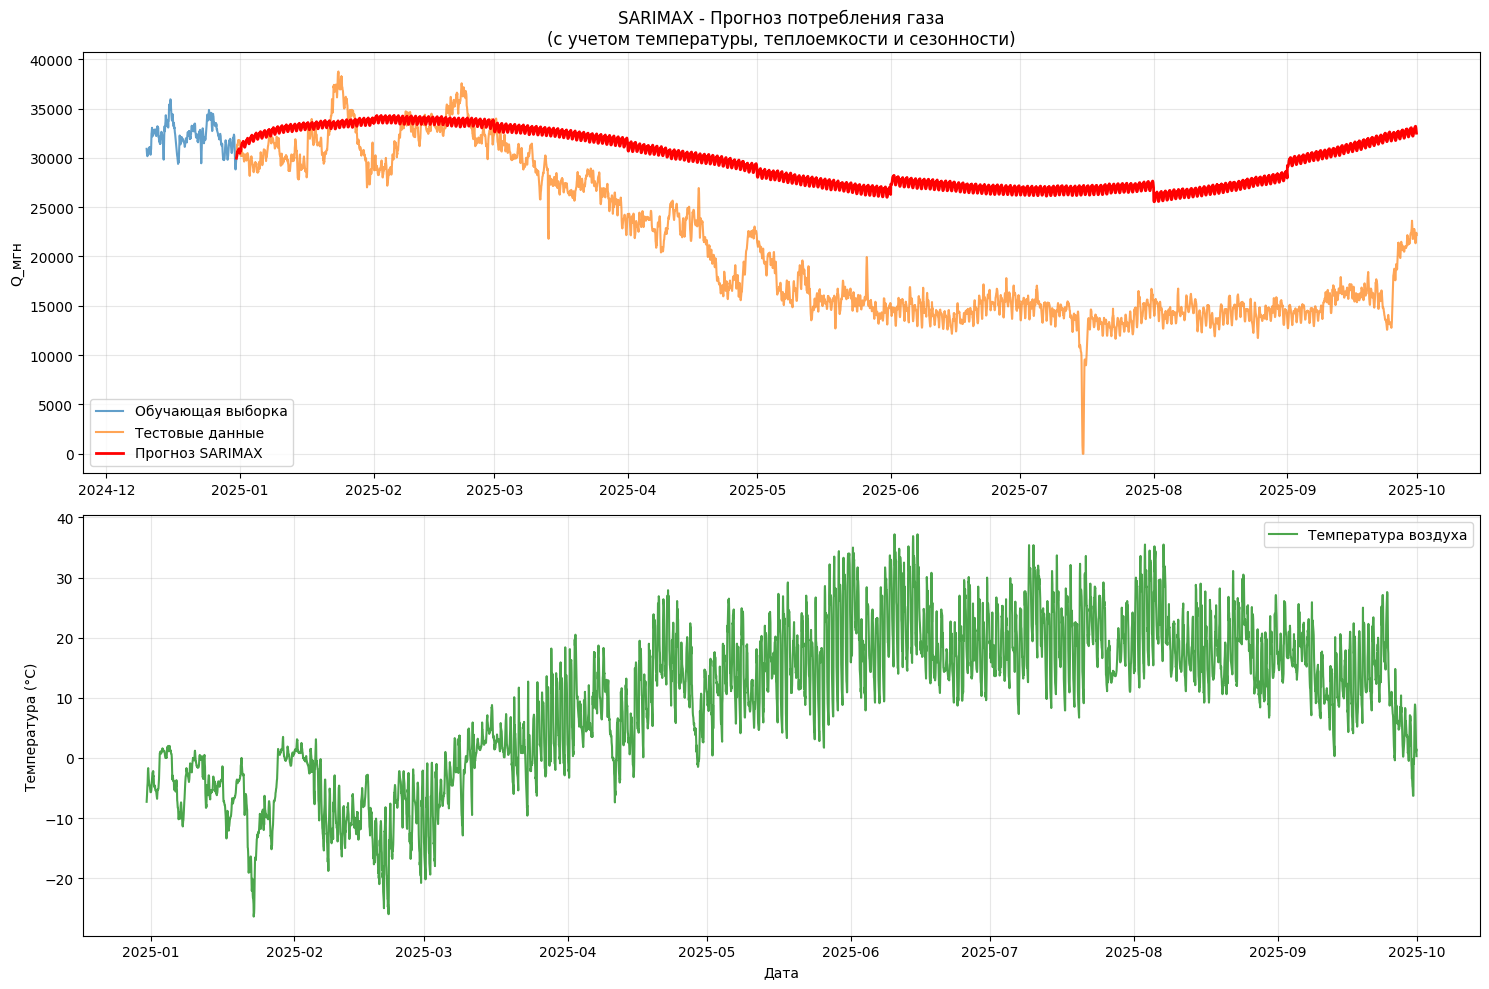

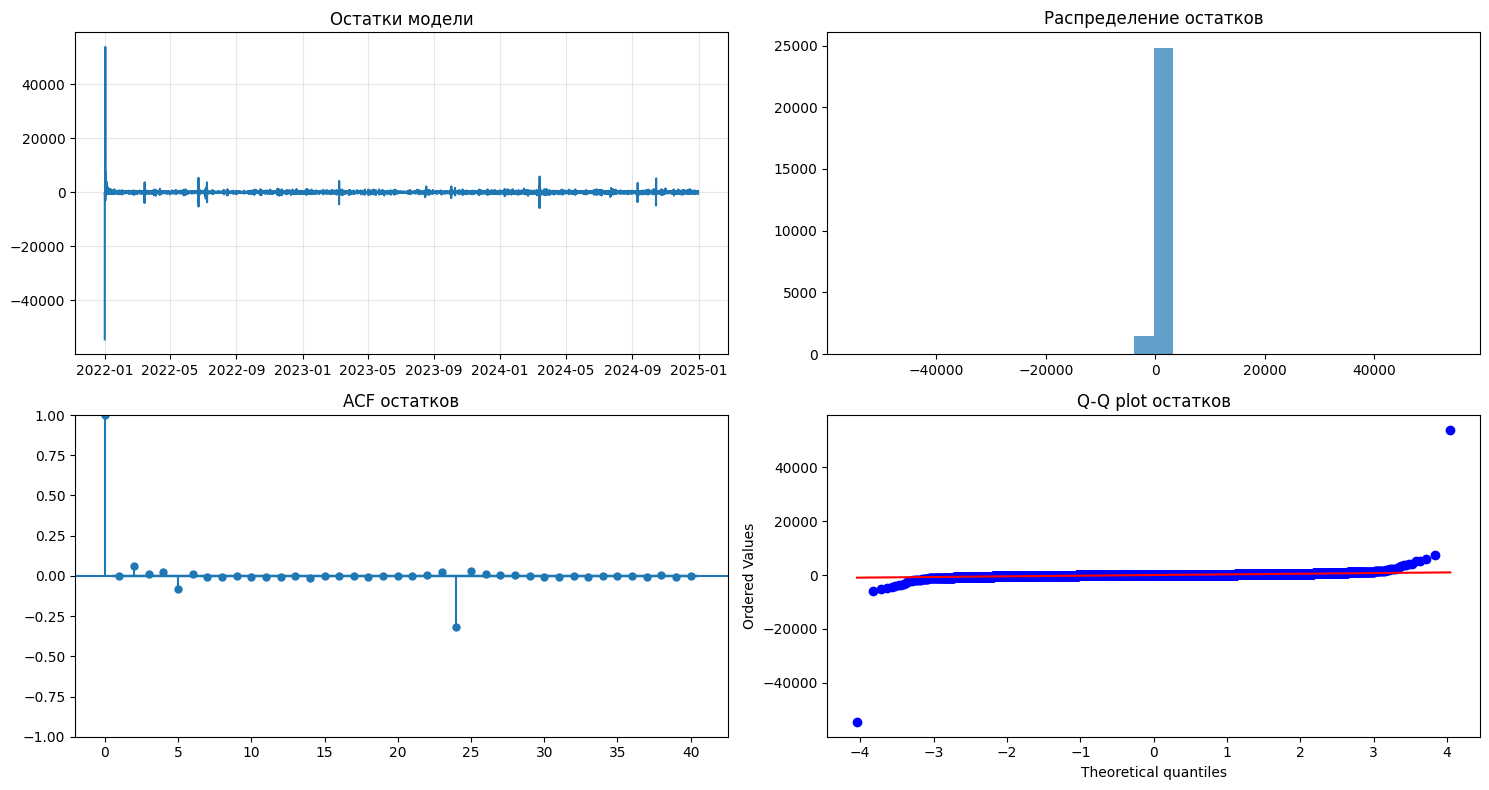

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# Создаем дополнительные признаки для учета годовой сезонности
df_filled['month'] = df_filled.index.month
df_filled['day_of_year'] = df_filled.index.dayofyear
df_filled['hour'] = df_filled.index.hour

# Синус-косинус преобразования для годовой сезонности
df_filled['year_sin'] = np.sin(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['year_cos'] = np.cos(2 * np.pi * df_filled['day_of_year'] / 365)

# Синус-косинус для суточной сезонности
df_filled['day_sin'] = np.sin(2 * np.pi * df_filled['hour'] / 24)
df_filled['day_cos'] = np.cos(2 * np.pi * df_filled['hour'] / 24)

# Взять подвыборку для стабильности вычислений
#sample_size = min(5000, len(df_filled))
#df_sample = df_filled.iloc[sample_size:10000].copy()
df_sample = df_filled.copy()
print(f"Работаем с подвыборкой: {len(df_sample)} записей")

# Разделение на train/test
train_size = int(len(df_sample) * 0.8)
train = df_sample['Q_мгн'][:train_size]
test = df_sample['Q_мгн'][train_size:]

# Подготовка экзогенных переменных
exog_vars = ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
exog_train = df_sample[exog_vars][:train_size]
exog_test = df_sample[exog_vars][train_size:train_size+len(test)]

print(f"Размер обучающей выборки: {len(train)}")
print(f"Размер тестовой выборки: {len(test)}")
print(f"Экзогенные переменные: {exog_vars}")

# SARIMAX модель с суточной сезонностью
try:
    # SARIMAX(1,0,1)(1,0,1,24) с экзогенными переменными
    model = SARIMAX(train,
                  exog=exog_train,
                  order=(1, 0, 1),           # (p,d,q)
                  seasonal_order=(1, 0, 1, 24), # Суточная сезонность
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarimax_fit = model.fit(disp=False, low_memory=True, maxiter=50)
    
    print("=" * 60)
    print("SARIMAX(1,0,1)(1,0,1,24) - Результаты:")
    print("=" * 60)
    print(sarimax_fit.summary())
    
    # Прогноз
    forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)
    
    # Метрики качества
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mse)
    
    print(f"\nМетрики качества:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"AIC: {sarimax_fit.aic:.2f}")
    
    # Визуализация
    plt.figure(figsize=(15, 10))
    
    # Основной график
    plt.subplot(2, 1, 1)
    plt.plot(train.index[-500:], train.values[-500:], label='Обучающая выборка', alpha=0.7)
    plt.plot(test.index, test.values, label='Тестовые данные', alpha=0.7)
    plt.plot(test.index, forecast, label='Прогноз SARIMAX', color='red', linewidth=2)
    plt.title('SARIMAX - Прогноз потребления газа\n(с учетом температуры, теплоемкости и сезонности)')
    plt.ylabel('Q_мгн')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График температуры
    plt.subplot(2, 1, 2)
    plt.plot(test.index, df_sample['Т_воздуха'][train_size:train_size+len(test)], 
             label='Температура воздуха', color='green', alpha=0.7)
    plt.ylabel('Температура (°C)')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ остатков
    residuals = sarimax_fit.resid
    
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(residuals)
    plt.title('Остатки модели')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.title('Распределение остатков')
    
    plt.subplot(2, 2, 3)
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(residuals, ax=plt.gca(), lags=40, title='ACF остатков')
    
    plt.subplot(2, 2, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot остатков')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при построении SARIMAX: {e}")
    
    # Резервный вариант - простая SARIMAX без сезонности
    print("\nПробуем упрощенную модель SARIMAX без сезонности...")
    try:
        model_simple = SARIMAX(train,
                             exog=exog_train[['Т_воздуха', 'Теплоемкость']],
                             order=(1, 0, 1),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        
        simple_fit = model_simple.fit(disp=False)
        forecast_simple = simple_fit.forecast(steps=len(test), 
                                           exog=exog_test[['Т_воздуха', 'Теплоемкость']])
        
        mse_simple = mean_squared_error(test, forecast_simple)
        print(f"Упрощенная SARIMAX - MSE: {mse_simple:.2f}")
        
    except Exception as e2:
        print(f"Ошибка в упрощенной модели: {e2}")

In [ ]:
try:
    model_weekly = SARIMAX(train,
                         exog=exog_train[['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos']],
                         order=(1, 0, 1),
                         seasonal_order=(1, 0, 1, 168),  # Недельная сезонность
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    
    weekly_fit = model_weekly.fit(disp=False, low_memory=True, maxiter=50)
    forecast_weekly = weekly_fit.forecast(steps=len(test), 
                                       exog=exog_test[['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos']])
    
    mse_weekly = mean_squared_error(test, forecast_weekly)
    print(f"SARIMAX с недельной сезонностью - MSE: {mse_weekly:.2f}")

SyntaxError: incomplete input (1455316702.py, line 14)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima



# Создаем признаки для годовой и суточной сезонности
df_filled['month'] = df_filled.index.month
df_filled['day_of_year'] = df_filled.index.dayofyear
df_filled['hour'] = df_filled.index.hour
df_filled['year_sin'] = np.sin(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['year_cos'] = np.cos(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['day_sin'] = np.sin(2 * np.pi * df_filled['hour'] / 24)
df_filled['day_cos'] = np.cos(2 * np.pi * df_filled['hour'] / 24)

# Взять подвыборку для скорости
sample_size = min(4000, len(df_filled))
df_sample = df_filled.iloc[:sample_size].copy()

# Разделение на train/test
train_size = int(len(df_sample) * 0.8)
train = df_sample['Q_мгн'][:train_size]
test = df_sample['Q_мгн'][train_size:]

# Подготовка экзогенных переменных
exog_vars = ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
exog_train = df_sample[exog_vars][:train_size]
exog_test = df_sample[exog_vars][train_size:train_size+len(test)]

print(f"Размеры: train={len(train)}, test={len(test)}")

# Автоматический подбор SARIMAX с помощью auto_arima
print("Начинаем автоматический подбор параметров SARIMAX...")
print("Это может занять несколько минут...")

# Вариант 1: Быстрый поиск с ограниченными параметрами
model_auto = auto_arima(
    train,
    exogenous=exog_train,
    seasonal=True,
    m=24,  # Суточная сезонность
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,  # Автоподбор дифференцирования
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Ускоренный поиск
    n_fits=30,      # Ограничиваем количество моделей для тестирования
    random_state=42,
    information_criterion='aic'
)

print("\n" + "="*60)
print("ЛУЧШАЯ МОДЕЛЬ НАЙДЕНА!")
print("="*60)
print(model_auto.summary())

# Прогноз с лучшей моделью
forecast_auto = model_auto.predict(n_periods=len(test), exogenous=exog_test)

# Метрики качества
mse = mean_squared_error(test, forecast_auto)
mae = mean_absolute_error(test, forecast_auto)
rmse = np.sqrt(mse)

print(f"\nМетрики качества AUTO-SARIMAX:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"AIC: {model_auto.aic():.2f}")

# Визуализация результатов
plt.figure(figsize=(15, 10))

# Основной график
plt.subplot(2, 1, 1)
plt.plot(train.index[-500:], train.values[-500:], label='Обучающая выборка', alpha=0.7)
plt.plot(test.index, test.values, label='Тестовые данные', alpha=0.7)
plt.plot(test.index, forecast_auto, label='Прогноз AUTO-SARIMAX', color='red', linewidth=2)
plt.title(f'AUTO-SARIMAX {model_auto.order}x{model_auto.seasonal_order} - Прогноз потребления газа')
plt.ylabel('Q_мгн')
plt.legend()
plt.grid(True, alpha=0.3)

# Ошибки прогноза
plt.subplot(2, 1, 2)
errors = test.values - forecast_auto
plt.plot(test.index, errors, label='Ошибки прогноза', color='orange')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.fill_between(test.index, -rmse, rmse, color='red', alpha=0.1, label=f'±RMSE ({rmse:.1f})')
plt.title('Ошибки прогноза')
plt.ylabel('Ошибка')
plt.xlabel('Дата')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Детальный анализ остатков
print("\nАнализ остатков лучшей модели:")
residuals = model_auto.resid()

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(residuals)
plt.title('Остатки модели')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(residuals, bins=30, alpha=0.7, density=True)
plt.title('Распределение остатков')

plt.subplot(2, 3, 3)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=plt.gca(), lags=40, title='ACF остатков')

plt.subplot(2, 3, 4)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(residuals, ax=plt.gca(), lags=20, method='ywm', title='PACF остатков')

plt.subplot(2, 3, 5)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков')

plt.subplot(2, 3, 6)
plt.scatter(forecast_auto, test.values, alpha=0.5)
min_val = min(forecast_auto.min(), test.min())
max_val = max(forecast_auto.max(), test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Прогноз')
plt.ylabel('Факт')
plt.title('Прогноз vs Факт')

plt.tight_layout()
plt.show()

# Сравнение с ручной моделью
print("\nСравнение с ранее выбранной моделью:")
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # Ваша предыдущая модель
    manual_model = SARIMAX(train,
                         exog=exog_train,
                         order=(1, 0, 1),
                         seasonal_order=(1, 0, 1, 24),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    
    manual_fit = manual_model.fit(disp=False)
    forecast_manual = manual_fit.forecast(steps=len(test), exog=exog_test)
    
    mse_manual = mean_squared_error(test, forecast_manual)
    
    print(f"Ручная модель SARIMA(1,0,1)(1,0,1,24):")
    print(f"  MSE: {mse_manual:.2f}")
    print(f"  AIC: {manual_fit.aic:.2f}")
    
    print(f"\nАвтоматическая модель {model_auto.order}x{model_auto.seasonal_order}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  AIC: {model_auto.aic():.2f}")
    
    improvement = ((mse_manual - mse) / mse_manual) * 100
    print(f"\nУлучшение MSE: {improvement:+.1f}%")
    
except Exception as e:
    print(f"Не удалось сравнить с ручной моделью: {e}")

# Прогноз на будущее (пример)
print("\nПример прогноза на следующие 24 часа:")
future_steps = 24
last_train_point = train_size

# Для прогноза нужны будущие значения экзогенных переменных
# В реальности их нужно предсказать или взять из прогноза погоды
# Здесь для примера используем последние известные значения
future_exog = exog_test.iloc[:future_steps]

future_forecast = model_auto.predict(n_periods=future_steps, exogenous=future_exog)

plt.figure(figsize=(15, 6))
last_points = 100
plt.plot(df_sample.index[train_size-last_points:train_size], 
         df_sample['Q_мгн'][train_size-last_points:train_size], 
         label='Исторические данные')
plt.plot(pd.date_range(start=df_sample.index[train_size], periods=future_steps, freq='H'),
         future_forecast, label='Прогноз на 24 часа', color='red', linewidth=2)
plt.title('Прогноз потребления газа на следующие 24 часа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Размеры: train=3200, test=800
Начинаем автоматический подбор параметров SARIMAX...
Это может занять несколько минут...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=52661.780, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=52349.646, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=52236.279, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=52659.835, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=52252.526, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=52232.188, Time=6.76 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=44.82 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=52659.033, Time=4.55 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=52192.121, Time=12.39 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=52196.168, Time=2.50 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=56.47 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept  

MemoryError: Unable to allocate 63.5 MiB for an array with shape (51, 51, 3200) and data type float64